# ML4Earth Hackathon Starter Notebook

This notebook gives a starting point for your participation in the [ML4Earth Hackathon 2024](https://ml4earth24.devpost.com/). In this notebook, we will cover loading the dataset, and finetuning an existing foundation model for this task. For this tutorial, we will use a foundation model from the [Satlas Pretrain](https://github.com/allenai/satlaspretrain_models/) family.

# Setup

Before we can begin, we need to install some libraries and download the model and dataset.

In [ ]:
!pip install -q torchgeo satlaspretrain_models

In [ ]:
# @title Import libraries { display-mode: "form" }
import yaml
import torch
import torchgeo
import torchgeo.datasets
import torchmetrics
import rich
import logging

import satlaspretrain_models

import lightning
from lightning.pytorch.callbacks import RichProgressBar
from torchgeo.datamodules import LandCoverAIDataModule
from torchgeo.trainers import SemanticSegmentationTask

import warnings
warnings.filterwarnings("ignore")

logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


device(type='cuda')

# Dataset setup

We use the [torchgeo](https://torchgeo.readthedocs.io/en/stable/) library to load the dataset. This will take a while as the dataset needs to be downloaded and pre-processed.

In [ ]:
datamodule = LandCoverAIDataModule(root="data/landcoverai", batch_size=16, num_workers=2, download=True)
datamodule.prepare_data()

100%|██████████| 1538212277/1538212277 [01:48<00:00, 14210190.41it/s]


Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Processed N-

Now that we've loaded the data, let's look at some examples from the training dataset:

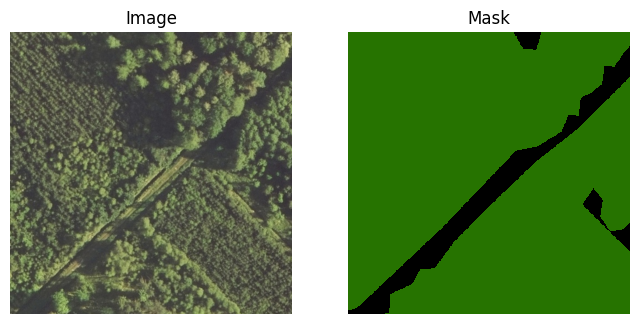

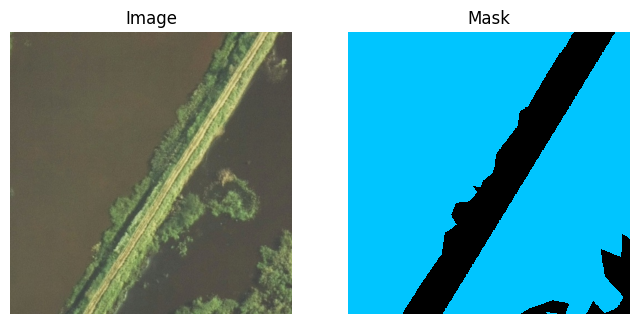

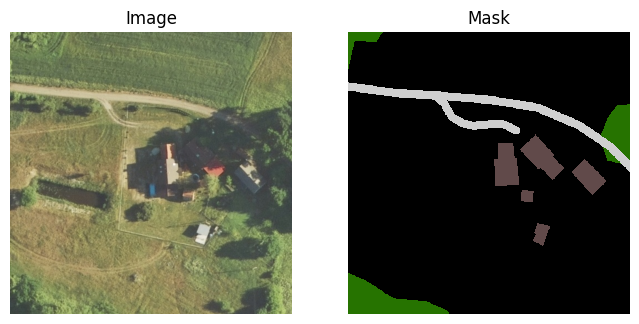

In [ ]:
datamodule.setup('fit')
for i in [0, 100, 246]:
  datamodule.plot(datamodule.train_dataset[i])

The dataset has 5 classes: background (black), building (brown), woodland (green), water (blue) and road (gray)

# Model Definition

In [ ]:
# Small helper class to make SatlasPretrain compatible with the torchgeo trainers
class SegmentationHeadHelper(torch.nn.Module):
  def forward(self, x):
    return x[0]

class SatlasSegmentationTask(SemanticSegmentationTask):
  def configure_models(self):
    weights_manager = satlaspretrain_models.Weights()
    model = weights_manager.get_pretrained_model(
      model_identifier="Aerial_SwinB_SI" ,
      fpn=True,  # Use an FPN block
      num_categories=5,
      head=satlaspretrain_models.Head.SEGMENT,  # The task is a segmentation task
      device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    self.model = torch.nn.Sequential(model, SegmentationHeadHelper())

In [ ]:
# Small helper class to log training and validation accuracies
class LogMetrics(lightning.Callback):
  def on_train_epoch_end(self, trainer, pl_module):
    console = rich.get_console()

    console.print('Train',
          ', '.join(f'{k.removeprefix("train_")}: {v:.02f}'
          for k, v in trainer.callback_metrics.items()
          if k.startswith('train_')), style='grey70', highlight=False
    )
    console.print('Val  ',
          ', '.join(f'{k.removeprefix("val_")}: {v:.02f}'
          for k, v in trainer.callback_metrics.items()
          if k.startswith('val_')))
    console.print()

# Finetuning

For Finetuning, we simply train all weights of the pretrained model for some additional epochs on our downstream dataset.

In [ ]:
module = SatlasSegmentationTask(num_classes=5, loss="ce", lr=1e-3)

# Freeze backbone
for param in module.model[0].backbone.parameters():
    param.requires_grad = False

In [ ]:
trainer = lightning.Trainer(accelerator="gpu", max_epochs=2, callbacks=[LogMetrics(), RichProgressBar(leave=True)])
trainer.fit(module, datamodule=datamodule)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ Sequential       │ 89.7 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ MetricCollection │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 87.9 M                                                                                       
Total params: 89.7 M                                                                                               
Total estimated model params size (MB): 358                                                                        
Modules in train mode: 484                                                                                         
Modules in eval mode: 0

Output()

Train loss: 1.23, MulticlassAccuracy: 0.68, MulticlassJaccardIndex: 0.51

Val   loss: 1.30, MulticlassAccuracy: 0.60, MulticlassJaccardIndex: 0.43

Output()

Train loss: 1.10, MulticlassAccuracy: 0.81, MulticlassJaccardIndex: 0.68

Val   loss: 1.30, MulticlassAccuracy: 0.60, MulticlassJaccardIndex: 0.43

# Testing

Finally, once we are happy with our training, we can evaluate the model on the test dataset:

In [16]:
trainer.test(module, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_MulticlassAccuracy   │     0.5713157057762146      │
│ test_MulticlassJaccardIndex │     0.39988937973976135     │
│          test_loss          │     1.3335156440734863      │
└─────────────────────────────┴─────────────────────────────┘

[{'test_loss': 1.3335156440734863,
  'test_MulticlassAccuracy': 0.5713157057762146,
  'test_MulticlassJaccardIndex': 0.39988937973976135}]

# Next Steps

Now it's your turn! Will you choose another foundation model? Will you use plain fine-tuning or experiment with more advanced methods like [LoRA](https://huggingface.co/docs/peft/en/package_reference/lora)? We're excited for your submissions!